In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

## BERT Import

In [3]:
bert_dir = "./bertModel/"

bert_base = "multi_cased_L-12_H-768_A-12"
bert_small = "uncased_L-8_H-512_A-8"
bert_smaller = "uncased_L-4_H-512_A-8"

gs_folder_bert = bert_dir+bert_base
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.meta',
 'bert_model.ckpt.index',
 'vocab.txt',
 'bert_model.ckpt.data-00000-of-00001']

## Dataset load

#### 데이터 셋 설명
- Microsoft Research Paraphrase Corpus가 온라인 뉴스 소스에서 자동으로 추출된 문장 쌍의 모음
- 쌍의 문장이 의미상 동일한 지의 여부에 대해 사람이 만든 주석을 포함함

In [4]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

In [5]:
list(glue.keys())

['train', 'validation', 'test']

#### "info" 객체는 데이터 셋 및 그 기능에 대한 설명

In [6]:
print(info.features)
print(f"\n the classes of dataset: {info.features['label'].names}")

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

 the classes of dataset: ['not_equivalent', 'equivalent']


#### Training Set에서 한 샘플

In [7]:
glue_train = glue['train']

for key, value in glue_train.items():
    print(f"{key:9s}: {value[0].numpy()}")

idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'


## BERT Tokenizer

불러온 pretrain된 BERT 모델과 vocab.txt에 등록된 tokens에 따른 tokenizer를 생성

In [8]:
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file = os.path.join(gs_folder_bert, "vocab.txt"), 
    do_lower_case = True ## 소문자로 고침
)

print(f"Vocab size: {len(tokenizer.vocab)}")

Vocab size: 119547


In [9]:
# 문장을 토큰화
tokens = tokenizer.tokenize("Hello Tensorflow!")
print(f"토큰화된 문장 : {tokens}")

# 토큰들을 인덱싱화
ids = tokenizer.convert_tokens_to_ids(tokens)
print(f"인덱싱화 된 토큰 : {ids}")

토큰화된 문장 : ['hell', '##o', 'ten', '##sor', '##flow', '!']
인덱싱화 된 토큰 : [61694, 10133, 11769, 28919, 105739, 106]


## Data Preprocessing

#### [SEP] Token 추가

In [10]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s.numpy()))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [11]:
sentence1 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence1"]])
sentence2 = tf.ragged.constant([
    encode_sentence(s) for s in glue_train["sentence2"]])

#### [CLS] Token 추가

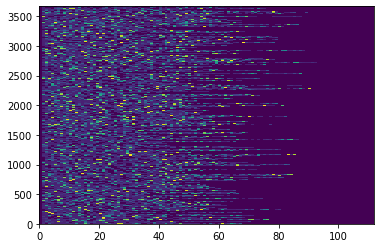

In [12]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

#### Mask and input type

#### input Mask
- 패딩과 내용을 선명히 구분짓게 하기위해 input Mask를 사용
- 패딩인 곳은 0을, 내용이 들어가는 부분은 1을 사용

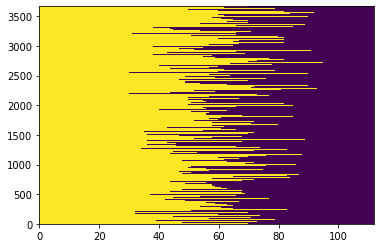

In [13]:
input_mask = tf.ones_like(input_word_ids).to_tensor()
plt.pcolormesh(input_mask)

#### input type
- Seperate embedding을 주기 위해 input type을 사용
- sequence1에는 0을 sequence2에는 1을 사용

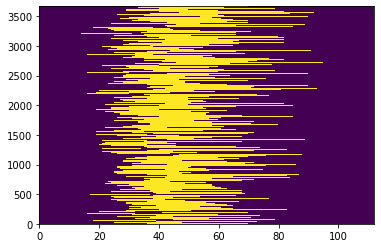

In [14]:
type_cls = tf.zeros_like(cls)
type_s1 = tf.zeros_like(sentence1)
type_s2 = tf.ones_like(sentence2)
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis = -1).to_tensor()

plt.pcolormesh(input_type_ids)

#### 종합 :

In [15]:
# [SEP] 토큰 추가하는 함수
def encode_sentence(s, tokenizer):
    tokens = list(tokenizer.tokenize(s.numpy()))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

# [CLS] 토큰 추가 및 BERT에 필요한 입력 요소들을 생성하는 함수
def bert_encode(glue_dict, tokenizer):
    num_examples = len(glue_dict["sentence1"])

    sentence1 = tf.ragged.constant([
        encode_sentence(s, tokenizer) for s in glue_dict["sentence1"]])
    sentence2 = tf.ragged.constant([
        encode_sentence(s, tokenizer) for s in glue_dict["sentence2"]])
    
    # CLS 토큰 선언
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0] 
    
    # CLS 토큰을 통해 sentense1과 sentense2를 통합
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1) 
    
    input_mask = tf.ones_like(input_word_ids).to_tensor() 

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    
    input_type_ids = tf.concat(
        [type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}

    return inputs

In [16]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

## Model

#### Model implement
- load the pre-trained BERT Model

#### BERT 모델 정의

In [17]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

In [18]:
config_dict

{'attention_probs_dropout_prob': 0.1,
 'directionality': 'bidi',
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'pooler_fc_size': 768,
 'pooler_num_attention_heads': 12,
 'pooler_num_fc_layers': 3,
 'pooler_size_per_head': 128,
 'pooler_type': 'first_token_transform',
 'type_vocab_size': 2,
 'vocab_size': 119547}

- 정의한 parameter들에 대한 BERT의 인코더와 분류기를 반환 

In [19]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(
    bert_config, num_labels=2)

In [20]:
glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[ 0.0147273 ,  0.26615652],
       [-0.15612523,  0.1048886 ],
       [-0.05868465,  0.23385657],
       [ 0.00307757,  0.18046997],
       [ 0.03911594,  0.1972606 ],
       [-0.05426488,  0.12014326],
       [ 0.04804478,  0.10972693],
       [-0.01277722,  0.24642962],
       [-0.21832494,  0.10097876],
       [-0.03149541,  0.38252228]], dtype=float32)

#### 인코더 가중치 복원

- 인코더가 빌드되면 임의로 초기화됨
- 체크 포인트에서 인코더의 가중치를 복원

In [21]:
checkpoint = tf.train.Checkpoint(encoder = bert_encoder)
#checkpoint.read(
#    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

#### 하이퍼 파라미터 정의

In [22]:
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch*epochs
warmup_steps = int(epochs*train_data_size*0.1/batch_size)

# Optimizer 정의
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)


- Adam을 사용하는 Optimizer인지 확인

In [23]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

# 모델 Training

#### 모델 컴파일

In [24]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

#### 모델 훈련

In [25]:
bert_classifier.fit(
        glue_train, glue_train_labels,
        validation_data=(glue_validation, glue_validation_labels),
        batch_size=32,
        epochs = 10)

Epoch 1/10
115/115 [==============================] - 55s 390ms/step - loss: 0.6552 - accuracy: 0.6611 - val_loss: 0.6191 - val_accuracy: 0.6838
Epoch 2/10
115/115 [==============================] - 44s 384ms/step - loss: 0.6239 - accuracy: 0.6752 - val_loss: 0.5995 - val_accuracy: 0.6716
Epoch 3/10
115/115 [==============================] - 45s 389ms/step - loss: 0.5780 - accuracy: 0.6984 - val_loss: 0.6007 - val_accuracy: 0.6765
Epoch 4/10
115/115 [==============================] - 45s 395ms/step - loss: 0.5773 - accuracy: 0.6967 - val_loss: 0.6007 - val_accuracy: 0.6765
Epoch 5/10
115/115 [==============================] - 45s 392ms/step - loss: 0.5771 - accuracy: 0.7015 - val_loss: 0.6007 - val_accuracy: 0.6765
Epoch 6/10
115/115 [==============================] - 45s 394ms/step - loss: 0.5667 - accuracy: 0.7096 - val_loss: 0.6007 - val_accuracy: 0.6765
Epoch 7/10
115/115 [==============================] - 45s 390ms/step - loss: 0.5718 - accuracy: 0.7084 - val_loss: 0.6007 - val_ac

#### 모델 저장

In [26]:
export_dir = './saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets
